# Basic Cross-Validation Experiment on the ExtraSensory data set with Backend Comparison

## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

#Disable multi-threading in NumPy 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1"

## Import modules

In [2]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow performs four train/test experiments on the ExtraSensory data set sleeping prediction task to illustrate the use of different scheduler back ends. The data are loaded once, followed by four parallel copies of the remaining workflow, which includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, mean imputation and feature normalization. 

The demonstration compares the run time of three different workflow scheduler backends:  sequential, multithreaded, and multiprocess. We run the parallel schedulers with 1, 2 and 4 workers. We note that due to communication overhead between the master and worker threads in the multi-process backend, and issues with Python's global interpreter lock in the multi-threaded backend, parallel speedups can be less than linear even for seemingly embarassingly parallel tasks. Parallel speedups also depend on the number of avilable cores. Also note that this demo requires an extended run time. 

sequential 1
Running Scheduler sequential
  Running Sequential Scheduler

Running step ES Data Loader
  Loading Extrasensory pkl file...

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 285268x224

Running step Normalizer
  Normalizer: running matrix of size 285268x224

Running step EXP-TT: LR
  Fitting and testing LR

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 285268x224

Running step Normalizer
  Normalizer: running matrix of size 285268x224

Running step EXP-TT: LR
  Fitting and testing LR

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 285268x224

Running step Normalizer
  Normalizer: running matrix of size 285268x224

Running step EXP-TT: LR
  Fitting and testing LR

Running step Missing Data Column Filter

Running step M

Running: Missing Data Column Filter
Done: Missing Data Column Filter
Scheduled: Missing Label Filter
Running: Missing Data Column Filter
Done: Missing Data Column Filter
Scheduled: Missing Label Filter
Running: Missing Label Filter
Done: Missing Data Column Filter
Scheduled: Missing Label Filter
Running: Missing Label Filter
Done: Missing Data Column Filter
Scheduled: Missing Label Filter
Running: Missing Label Filter
Done: Missing Label Filter
Scheduled: Imputer
Running: Missing Label Filter
Done: Missing Label Filter
Scheduled: Imputer
Running: Imputer
Done: Missing Label Filter
Scheduled: Imputer
Running: Imputer
Done: Missing Label Filter
Scheduled: Imputer
  Imputer: Running on matrix of size 285268x224
Running: Imputer
Done: Imputer
Scheduled: Normalizer
  Imputer: Running on matrix of size 285268x224
Running: Imputer
Done: Imputer
Scheduled: Normalizer
  Imputer: Running on matrix of size 285268x224
Running: Normalizer
Done: Imputer
Scheduled: Normalizer
  Imputer: Running on ma

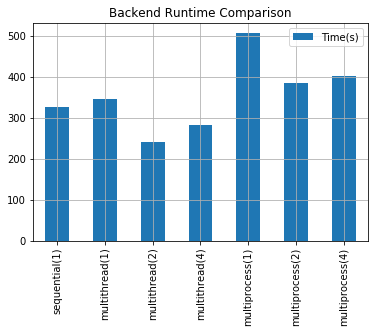

In [19]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=1000)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]

res       = []
df_raw    = extrasensory_data_loader(label="SLEEPING");
for i in range(4):
    df_cf     = MisingDataColumnFilter(df_raw);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       = res + ExpTrainTest(df_norm, estimators, metrics=metrics);

configs = {"sequential":[1],
           "multithread":[1,2,4],
           "multiprocess":[1,2,4]
          }

results={}
for config in configs:
    for workers in configs[config]:
        
        print(config, workers)
        flow=workflow(res);        
        start = time.time()
        output=flow.run(backend=config, num_workers=workers, monitor=False, from_scratch=True);
        results[config+"(%d)"%(workers)] = time.time()-start
        print(config, workers, results[config+"(%d)"%(workers)])
    
time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"))